In [1]:
import time

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from beamngpy import BeamNGpy, Vehicle, Scenario
from beamngpy.sensors import Electrics, Camera
import h5py

C:\Software\Anaconda_5.1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Adding front facing camera and attaching sensor to an ego vehicle

In [2]:
REPO_PATH =  r'E:\beamng_unlimited_repo\trunk'

beamng = BeamNGpy('localhost', 64256, home = REPO_PATH ) 

# Create a vehile instance that will be called 'ego' in the simulation
# using the etk800 model the simulator ships with
vehicle = Vehicle('ego', model='etk800', licence='PYTHON', colour='Green')
# Create an Electrics sensor and attach it to the vehicle
electrics = Electrics()
vehicle.attach_sensor('electrics', electrics)

pos = (-0.3, 3, 1.0)
direction = (0, 1, 0)
fov = 120
resolution = (320, 160)
SCENARIO_NAME = 'west_coast_usa'
    
front_camera = Camera(pos, direction, fov, resolution, colour=True, depth=True, annotation=True)
vehicle.attach_sensor('front_camera', front_camera)


scenario = Scenario(SCENARIO_NAME, 'vehicle_state')


scenario.add_vehicle(vehicle, pos=(-752.5349731445313,-914.7130126953125,163.1999969482422), rot=(0, 0, 45))  # 45 degree rotation around the z-axis

# The make function of a scneario is used to compile the scenario and produce a scenario file the simulator can load
scenario.make(beamng)

### Instantiating BeamNG simulator

In [3]:
try:    
    bng = beamng.open()
    bng.load_scenario(scenario)
    bng.start_scenario()

except Exception:
    bng.close()

In [4]:
vehicle.ai_set_mode('span')   # Setting BeamNG drive through the road to collect the data
vehicle.ai_drive_in_lane(True)
vehicle.ai_set_aggression(0.6) # Agression mode is set to average value.


positions = list()
directions = list()
wheel_speeds = list()
throttles = list()
brakes = list()
steer = list()
camera = list()

### Collecting various trainable parameters

In [ ]:
vehicle.update_vehicle()
sensors = bng.poll_sensors(vehicle)

print('The vehicle position is:')
display(vehicle.state['pos'])

print('The vehicle direction is:')
display(vehicle.state['dir'])

print('The wheel speed is:')
display(sensors['electrics']['values']['wheelspeed'])

print('The throttle intensity is:')
display(sensors['electrics']['values']['throttle'])

print('The brake intensity is:')
display(sensors['electrics']['values']['brake'])

for _ in range(9999999):
    time.sleep(0.05)
    vehicle.update_vehicle()  # Synchs the vehicle's "state" variable with the simulator
    sensors = bng.poll_sensors(vehicle)  # Polls the data of all sensors attached to the vehicle
    positions.append(vehicle.state['pos'])
    directions.append(vehicle.state['dir'])
    steer.append(sensors['electrics']['values']['steering'])
    wheel_speeds.append(sensors['electrics']['values']['wheelspeed'])
    throttles.append(sensors['electrics']['values']['throttle'])
    brakes.append(sensors['electrics']['values']['brake'])
    camera.append(sensors['front_camera'])
    
    


## Data collected from the sensor readings: Displaying first 10 readings

### Steering angles

In [8]:
print ('Steering angles: \n', steer[:10])

Steering angles: 
 [-441.03027014787585, -510, -510, -428.8600057911102, -339.5463719701333, -253.4017629254953, -178.76021339182472, -92.24659975237944, -44.11933860143744, -6.009753169785415]


### Throttle

In [9]:
print ('Throttle: \n', throttles[:10])

Throttle: 
 [0.27595230404197885, 0.17902877239855186, 0.11793938574289593, 0.29217729810120346, 0.21600178069203227, 0.03446548807440686, 0.16592427888847783, 0.2932964259935836, 0.11016573006320121, 0.32858488529077606]


### Brakes

In [10]:
print ('Brakes: \n', brakes[:10])

Brakes: 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


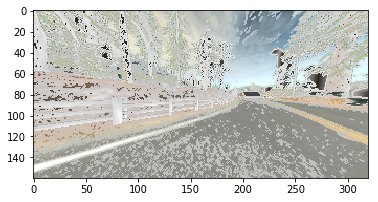

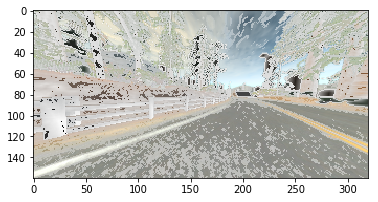

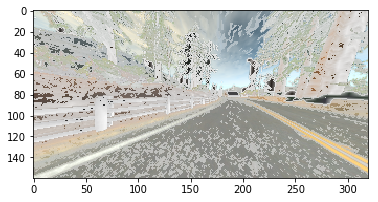

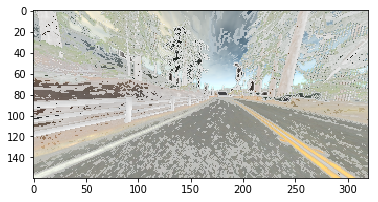

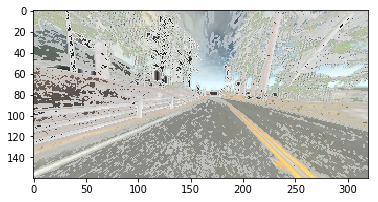

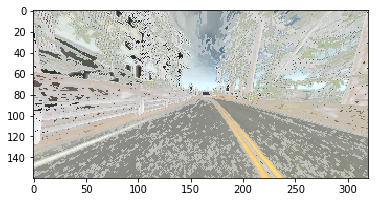

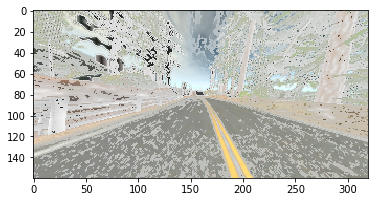

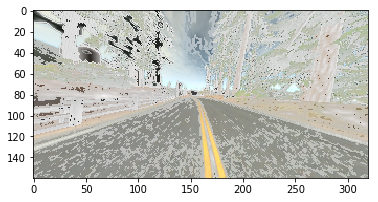

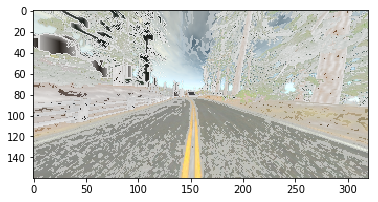

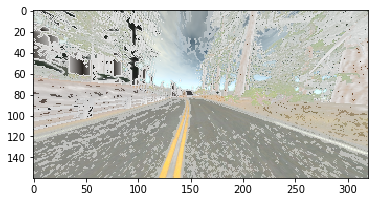

In [14]:
import numpy as np
import matplotlib.pyplot as plt
cnt = 0

for item in camera:  
    plt.imshow(np.asarray(item['colour']))
    plt.show()
    cnt += 1
    if cnt>=10: break

In [7]:
annotation = list()
colour = list()
depth = list()

for items in camera:
    #annotation.append(np.asarray(items['annotation']))
    colour.append(np.asarray(items['colour']))
    depth.append(np.asarray(items['depth']))

### Saving the collected data in HDF5 format

In [8]:
PATH = r'E:\beamng data collection\new\utah_11_01_2020_20_12.h5'

with h5py.File(PATH, 'w') as hdf:
    g1 = hdf.create_group('camera_readings')
    g1.create_dataset('annotation', data = annotation)
    g1.create_dataset('colour', data = colour)
    #g1.create_dataset('depth', data = depth)
    g2 = hdf.create_group('logs')
    g2.create_dataset('steering_angle', data = steer)
    g2.create_dataset('throttle', data = throttles)
    g2.create_dataset('brakes', data = brakes)